In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import fgsm

In [2]:
paviaU = scipy.io.loadmat('./PaviaU.mat')['paviaU']
paviaU_gt = scipy.io.loadmat('./PaviaU_gt.mat')['paviaU_gt']

In [3]:
Nmax = paviaU.max()
paviaU = (paviaU/Nmax).astype(np.float32)

In [4]:
paviaU = paviaU.reshape(610*340, 103)

In [5]:
pca = PCA(10)
paviaU_PCA = pca.fit_transform(paviaU)

In [6]:
#mms = MinMaxScaler()
#paviaU_PCA = mms.fit_transform(paviaU_PCA)

In [7]:
def getiim(size,band):
    hf = int(size/2)
    aa = np.zeros(((610*340),size,size,band))
    a = np.zeros((610+size, 340+size, band))
    a[hf:-hf,hf:-hf,:] = paviaU_PCA.reshape((610,340,band))
    count = 0
    output = []
    for i in range(size,610-1):
        for j in range(size,340-1):
            #print(i,j)
            aa[count] = a[i-hf:i+hf,j-hf:j+hf,:]
            #print(count)
            count = count+1
    return aa

In [8]:
data_im = getiim(8,10)

In [9]:
data_im.shape

(207400, 8, 8, 10)

In [10]:
X = data_im
y = paviaU_gt.reshape(207400)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
nsplit = int(0.2*len(paviaU_PCA))
X_train = X[:nsplit]
y_train = y[:nsplit]
X_val = X[nsplit:nsplit*2]
y_val = y[nsplit:nsplit*2]
X_test = X[nsplit*2:]
y_test = y[nsplit*2:]
X,y = None,None
data_im=None

In [11]:
y_train_encode = keras.utils.to_categorical(y_train)
y_val_encode = keras.utils.to_categorical(y_val)
y_test_encode = keras.utils.to_categorical(y_test)


In [12]:
fitModel = keras.models.load_model('./ovf100ep.h5')
fitModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 8, 8, 10)]        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              1312768   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               1049088   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656

In [13]:
pn_tr = fgsm.create_adversarial_pattern(tf.convert_to_tensor(X_train),y_train_encode,models=fitModel)

In [14]:
X_train_pn = X_train+0.005*pn_tr
y_train_pn = y_train
'''X_train2 = np.concatenate((X_train,X_train_pn))
y_train2 = np.concatenate((y_train,y_train_pn))
idx = np.random.permutation(len(X_train2))
X_train2 = X_train2[idx]
y_train2 = y_train2[idx]
X_train2 = X_train2[idx]
y_train2 = y_train2[idx]
y_train2_encode = keras.utils.to_categorical(y_train2)'''

'X_train2 = np.concatenate((X_train,X_train_pn))\ny_train2 = np.concatenate((y_train,y_train_pn))\nidx = np.random.permutation(len(X_train2))\nX_train2 = X_train2[idx]\ny_train2 = y_train2[idx]\nX_train2 = X_train2[idx]\ny_train2 = y_train2[idx]\ny_train2_encode = keras.utils.to_categorical(y_train2)'

In [15]:
X_train_pn.shape

TensorShape([41480, 8, 8, 10])

In [16]:
def nnmodel(input_shape):
    X_input = keras.layers.Input((input_shape))
    X = keras.layers.Flatten()(X_input)
    X = keras.layers.Dense(2048)(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Dense(512)(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Dense(512)(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Dense(10,activation='softmax')(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='model')
    return model

In [17]:
mymodel = nnmodel(X_train_pn[0].shape)
mymodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
mymodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 10)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              1312768   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656

In [18]:
mymodel.fit(X_train_pn,y_train_encode,batch_size=64,epochs=100,validation_data=(X_val,y_val_encode))

Train on 41480 samples, validate on 41480 samples
Epoch 1/100
41480/41480 [==============================] - 3s 65us/sample - loss: 0.7944 - accuracy: 0.8167 - val_loss: 0.9303 - val_accuracy: 0.7927
Epoch 2/100
41480/41480 [==============================] - 2s 52us/sample - loss: 0.6741 - accuracy: 0.8333 - val_loss: 0.9147 - val_accuracy: 0.7786
Epoch 3/100
41480/41480 [==============================] - 3s 78us/sample - loss: 0.6163 - accuracy: 0.8439 - val_loss: 1.0000 - val_accuracy: 0.7781
Epoch 4/100
41480/41480 [==============================] - 3s 68us/sample - loss: 0.5689 - accuracy: 0.8554 - val_loss: 1.0813 - val_accuracy: 0.7189
Epoch 5/100
41480/41480 [==============================] - 2s 53us/sample - loss: 0.5266 - accuracy: 0.8633 - val_loss: 1.0494 - val_accuracy: 0.7581
Epoch 6/100
41480/41480 [==============================] - 2s 52us/sample - loss: 0.4944 - accuracy: 0.8684 - val_loss: 1.1197 - val_accuracy: 0.7058
Epoch 7/100
41480/41480 [=========================

Epoch 55/100
41480/41480 [==============================] - 3s 80us/sample - loss: 0.0921 - accuracy: 0.9755 - val_loss: 3.1561 - val_accuracy: 0.6891
Epoch 56/100
41480/41480 [==============================] - 3s 73us/sample - loss: 0.0815 - accuracy: 0.9777 - val_loss: 3.0505 - val_accuracy: 0.6479
Epoch 57/100
41480/41480 [==============================] - 4s 91us/sample - loss: 0.0752 - accuracy: 0.9792 - val_loss: 3.3925 - val_accuracy: 0.6538
Epoch 58/100
41480/41480 [==============================] - 3s 79us/sample - loss: 0.0778 - accuracy: 0.9793 - val_loss: 3.2224 - val_accuracy: 0.6384
Epoch 59/100
41480/41480 [==============================] - 2s 54us/sample - loss: 0.0979 - accuracy: 0.9745 - val_loss: 3.0812 - val_accuracy: 0.6342
Epoch 60/100
41480/41480 [==============================] - 2s 53us/sample - loss: 0.0920 - accuracy: 0.9773 - val_loss: 3.5990 - val_accuracy: 0.5995
Epoch 61/100
41480/41480 [==============================] - 2s 53us/sample - loss: 0.0746 - ac

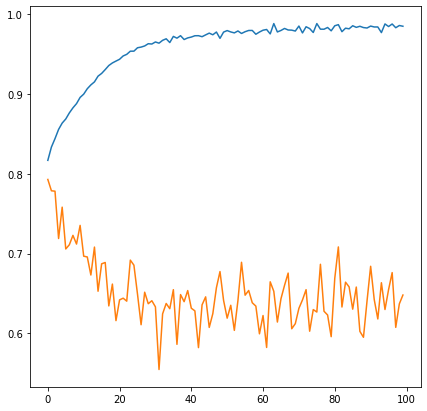

In [19]:
his = mymodel.history.history
plt.figure(figsize=(7,7))
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
#plt.savefig('ovf100ep.png')

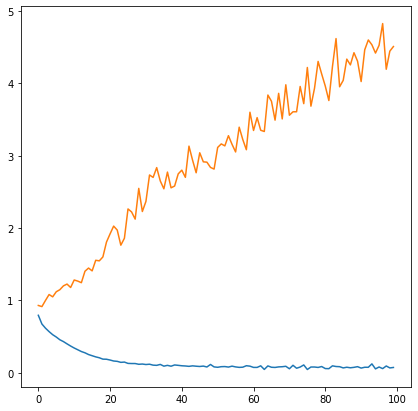

In [20]:
plt.figure(figsize=(7,7))
plt.plot(his['loss'])
plt.plot(his['val_loss'])

In [21]:
#mymodel.save('ovf100ep.h5')

In [22]:
print(classification_report(y_train,np.argmax(mymodel.predict(X_train),axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71     32870
           1       0.14      0.44      0.21      1293
           2       0.35      0.19      0.25      3763
           3       0.10      0.66      0.17       406
           4       0.09      0.59      0.16       624
           5       0.23      0.64      0.33       284
           6       0.31      0.45      0.36      1031
           7       0.15      0.55      0.24       262
           8       0.19      0.44      0.27       766
           9       0.23      0.60      0.33       181

    accuracy                           0.55     41480
   macro avg       0.26      0.52      0.30     41480
weighted avg       0.74      0.55      0.62     41480



In [23]:
print(classification_report(y_val,np.argmax(mymodel.predict(X_val),axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.57      0.66     32919
           1       0.04      0.13      0.06      1311
           2       0.14      0.07      0.09      3707
           3       0.02      0.12      0.03       414
           4       0.02      0.16      0.04       592
           5       0.02      0.06      0.03       281
           6       0.12      0.15      0.13      1057
           7       0.03      0.11      0.05       247
           8       0.04      0.08      0.05       740
           9       0.01      0.02      0.01       212

    accuracy                           0.47     41480
   macro avg       0.12      0.15      0.12     41480
weighted avg       0.65      0.47      0.54     41480



In [24]:
print(classification_report(y_test,np.argmax(mymodel.predict(X_test),axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.57      0.66     98835
           1       0.04      0.12      0.06      4027
           2       0.13      0.06      0.09     11179
           3       0.02      0.14      0.04      1279
           4       0.02      0.15      0.04      1848
           5       0.03      0.08      0.04       780
           6       0.10      0.14      0.12      2941
           7       0.04      0.13      0.06       821
           8       0.03      0.06      0.04      2176
           9       0.01      0.03      0.02       554

    accuracy                           0.47    124440
   macro avg       0.12      0.15      0.12    124440
weighted avg       0.65      0.47      0.54    124440



In [33]:
pn_tr2 = fgsm.create_adversarial_pattern(tf.convert_to_tensor(X_train),tf.convert_to_tensor(y_train_encode),fitModel)

In [34]:
pn_tr2.shape

TensorShape([41480, 8, 8, 10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


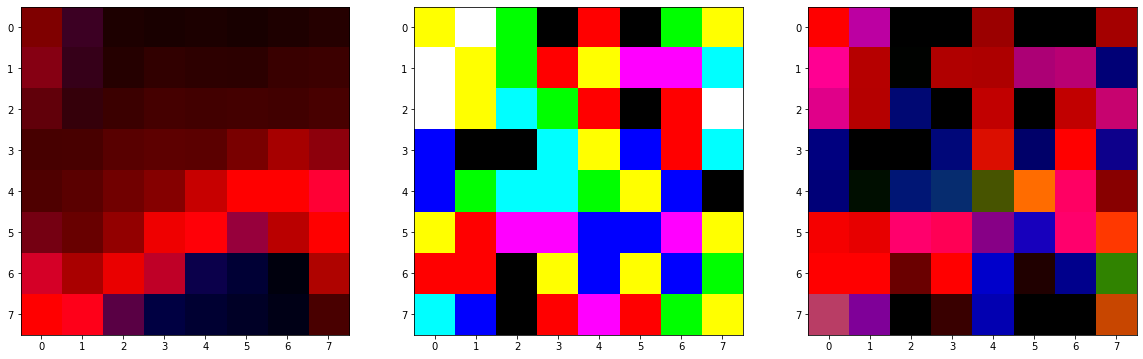

In [53]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,)
fig.set_figheight(20)
fig.set_figwidth(20)
ax1.imshow(X_train[212,:,:,:3])
ax2.imshow(pn_tr2[212,:,:,:3])
ax3.imshow(X_train[212,:,:,:3]+0.5*pn_tr2[212,:,:,:3])

In [36]:
pn_tr2.shape

TensorShape([41480, 8, 8, 10])

In [48]:
xatk = X_train+0.5*pn_tr2

In [49]:
mymodel.evaluate(xatk,y_train_encode,verbose=0)

[0.08780175065296814, 0.9947445]

In [50]:
mymodel.evaluate(X_train,y_train_encode,verbose=0)

[0.1872070882941981, 0.9518563]

In [51]:
print(classification_report(y_train,np.argmax(mymodel.predict(xatk),axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32913
           1       0.99      0.97      0.98      1350
           2       1.00      0.99      1.00      3708
           3       0.98      0.96      0.97       451
           4       0.99      0.93      0.96       603
           5       1.00      0.99      0.99       261
           6       0.98      0.98      0.98       970
           7       0.96      0.99      0.97       263
           8       0.98      0.98      0.98       778
           9       1.00      0.91      0.95       183

    accuracy                           0.99     41480
   macro avg       0.99      0.97      0.98     41480
weighted avg       0.99      0.99      0.99     41480



In [52]:
print(classification_report(y_train,np.argmax(mymodel.predict(X_train),axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     32913
           1       0.89      0.81      0.85      1350
           2       0.83      0.93      0.87      3708
           3       0.94      0.87      0.91       451
           4       0.98      0.77      0.86       603
           5       0.96      0.98      0.97       261
           6       0.90      0.94      0.92       970
           7       0.82      0.98      0.89       263
           8       0.80      0.88      0.84       778
           9       0.99      0.81      0.89       183

    accuracy                           0.95     41480
   macro avg       0.91      0.89      0.90     41480
weighted avg       0.95      0.95      0.95     41480

